# How To: Land-Use-Land-Cover Prediction for Slovenia - using the Batch Processing API


This notebook is based on the [Land-User-Land-Cover Prediction example](https://eo-learn.readthedocs.io/en/latest/examples/land-cover-map/SI_LULC_pipeline.html) described in the [EOLearn documentation](https://eo-learn.readthedocs.io/en/latest/index.html). The example workflow uses `EOLearn` to construct a machine learning pipeline for predicting the land use / land cover for the region of the Republic of Slovenia. The import of satellite images to train a model which is then used for the predictions is performed using an [EOTask](https://eo-learn.readthedocs.io/en/latest/eotasks.html) based on Sentinel Hub's [process API](https://docs.sentinel-hub.com/api/latest/api/process/). While this approach is efficient for most applications, querying large volumes of data and performing the processing steps locally can complicate scaling to larger areas (country or continent-wide analysis for example).

In this notebook, we present an alternative workflow, where the acquisition of the satellite data, processing of derived products and resampling over a fixed timestep is performed with Sentinel Hub services. The process allows for much faster processing times over large areas, reduced costs and the user needs less computational resources to process the data.

## Before you start
#### Requirements

In order to run the example you will need an EDC Sentinel Hub API access (Enterprise plan) to access satellite data and an [Amazon Bucket](https://aws.amazon.com/s3/) to save the outputs to.

To configure the notebook to work with your Sentinel Hub account you can use the `edc` configurator as shown below. You will also need to specify your Amazon Bucket access credentials (user id and secret for [programmatic access](https://docs.aws.amazon.com/general/latest/gr/aws-sec-cred-types.html#access-keys-and-secret-access-keys)).

**Note: You may need to update the `eolearn` and `sentinelhub` package to the latest version.**

#### Input data

You can access the example input data from the [Github repository](https://github.com/sentinel-hub/eo-learn/tree/master/examples/batch-processing/data)

## Overview

This notebook is organised in 2 main sections:

- **Part 1** is dedicated to creating and running the Batch Process with [Sentinel Hub Python package](https://sentinelhub-py.readthedocs.io/en/latest/).

- **Part 2** focusses on converting the results obtained in *Part 1* to [EOPatches](https://eo-learn.readthedocs.io/en/latest/examples/core/CoreOverview.html#EOPatch), the format used in [EOLearn](https://eo-learn.readthedocs.io/en/latest/index.html).

- **Part 3** shows how to integrate the workflow into the [LULC pipeline](https://github.com/sentinel-hub/eo-learn/blob/master/examples/land-cover-map/SI_LULC_pipeline.ipynb) to predict LULC using machine learning algorithms. 

Let’s start!


In [2]:
# Basics of Python data handling and visualization
import numpy as np
import geopandas as gpd
from shapely.geometry import Polygon
from shapely.wkt import loads
import rasterio

# Sentinel Hub
from sentinelhub import (SentinelHubBatch, SentinelHubRequest, Geometry, CRS, BBox, DataCollection, MimeType, SHConfig,
                         BatchSplitter)

# EOLearn
from eolearn.core import (EOPatch, EONode, EOWorkflow, EOExecutor, OverwritePermission, FeatureType, SaveTask, LoadTask,
                          linearly_connect_tasks)
from eolearn.geometry import VectorToRasterTask, ErosionTask
from eolearn.ml_tools import FractionSamplingTask

# Amazon
import boto3

# Utilities
from pathlib import Path, PosixPath
import datetime
from tqdm.auto import tqdm
from fs_s3fs import S3FS
from fs import open_fs
from aenum import MultiValueEnum
from time import sleep

# Visualisation
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.patches import Patch

import os
import warnings
warnings.filterwarnings('ignore')

In [3]:
%matplotlib inline

# Part 1: create and run the Batch process

Run `Sentinel Hub Batch Processing` to request data for an area of interest, and download the satellite products (bands and derived products) to an Amazon S3 Bucket.

First specify Amazon S3 bucket client ID and secret (See **Requirements** above)

In [4]:
AWS_ID = "aws-client-id"
AWS_SECRET = "aws-client-secret"

### Sentinel Hub authentification

In the following cell, we will create an instance of ```sentinelhub.SHConfig``` for the Sentinel Hub services. The token is only valid for 1 hour. If you get an message of type ` accessToken signature expired` later in the workflow, just re-run the next cell. See more [information here](https://docs.sentinel-hub.com/api/latest/api/overview/authentication/)

In [5]:
# Set up credentials for use with batch
config = SHConfig()
config.sh_client_id = os.environ["SH_CLIENT_ID"]
config.sh_client_secret = os.environ["SH_CLIENT_SECRET"]

if config.sh_client_id == '' or config.sh_client_secret == '':
    print("Warning! To use Sentinel Hub services, please provide the credentials (client ID and client secret).")

## 1.1 Define the Area-of-Interest (AOI):

Although the Sentinel Hub Batch processing is designed for large areas, running this example Notebook for the entire Republic of Slovenia would be costly (in terms of storage and processing units used). To make the example reproducible, we will run the example for a smaller region: the administrative boundaries of the capital, Ljubljana.


- A geographical shape of Slovenia was taken from [this webpage](http://alas.matf.bg.ac.rs/~mi09109/svn.html). The region of Ljubljana was extracted using QGIS and saved as a new geojson. In the following cell the `geojson` is imported and a buffer of 500 m is applied to it (to make sure to cover the entire extent). The shape `svn_border.geojson` is available [here](https://github.com/sentinel-hub/eo-learn/blob/master/examples/batch-processing/data/ljubljana.geojson).

- Because the Batch Processing API can't process shapes with too many coordinates (up to 1500 points are supported), a simplified polygon covering the extent of the geographical shape is created (using `simplify`), and the coordinates extracted. In the current example, this step is optional, but was included for demonstration purposes.

- The shape is split into smaller tiles by the batch process (see further down).

#### 1.1.1 Import data, plot AOI, and check the points count

In [6]:
ljubljana_data = {
    "adm1_code": "SVN-962",
    "Shape_Leng": 1.01284310866,
    "Shape_Area": 0.0321361298149,
    "diss_me": 962,
    "adm1_code_": "SVN-962",
    "iso_3166_2": "SI-",
    "wikipedia": None,
    "sr_sov_a3": "SVN",
    "sr_adm0_a3": "SVN",
    "iso_a2": "SI",
    "adm0_sr": 1,
    "admin0_lab": 2,
    "name": "Osrednjeslovenska",
    "name_alt": "Ljubljana",
    "name_local": None,
    "type": "Statisticna Regije",
    "type_en": "Statistical Region",
    "code_local": None,
    "code_hasc": "SI.LJ",
    "note": None,
    "hasc_maybe": None,
    "region": None,
    "region_cod": None,
    "region_big": None,
    "big_code": None,
    "provnum_ne": 111,
    "gadm_level": 2,
    "check_me": 0,
    "scalerank": 10,
    "datarank": 8,
    "abbrev": None,
    "postal": "LJ",
    "area_sqkm": 0.0,
    "sameascity": -99,
    "labelrank": 10,
    "featurecla": "Admin-1 scale rank",
    "admin": "Slovenia",
    "name_len": 17,
    "mapcolor9": 2,
    "mapcolor13": 12,
    "geometry": loads("POLYGON ((926425.6431983189 5123589.170469966, 928023.7898916167 5121898.015502713, 930381.3263176056 5121120.044066284, 932172.4018085758 5120986.554265775, 932397.4164062712 5120015.896563099, 932581.6593906969 5119111.593260468, 934172.9482895343 5118295.244651059, 935552.5077836656 5118035.394490954, 937426.0230920448 5118284.182013701, 938974.6457346278 5118919.953589984, 939436.4214525614 5118863.607289625, 940115.1034137213 5118470.883597136, 941661.5894687981 5118743.682363604, 942560.1680774961 5118144.887344502, 942735.089611518 5117724.728520735, 943609.3171581865 5117355.118745014, 943441.7280510126 5116506.263347512, 943476.1717744432 5116029.795751704, 943357.5915462442 5115669.221437243, 943883.7408222458 5115060.955142928, 944401.2580603813 5114573.278955945, 944833.0906094413 5113938.04334936, 945085.8948330702 5113278.305480363, 944854.481928225 5112644.071482883, 945156.6899264865 5110470.215581522, 944463.2053827948 5109883.358539728, 943213.6218703112 5110424.993391757, 942450.1435025067 5110975.866591577, 942002.8597709246 5111157.176478082, 941344.5252792852 5111086.772156567, 940250.6079617536 5110362.048641361, 939987.9768291702 5109818.169601077, 939577.3549704123 5109318.540062902, 938375.9969106899 5108514.419667248, 936051.6183637844 5108285.692598732, 934876.7259672079 5109033.28003256, 932469.7213315063 5110954.777737652, 930583.1400775139 5111205.907107501, 928967.0312091864 5110810.191967965, 928500.3034628865 5110414.20558999, 928620.5574546311 5109381.365577888, 928509.1394418445 5107865.126862759, 926900.3871498384 5108624.263870159, 926099.3870347773 5108522.555558871, 924410.7564367288 5107768.401844963, 923998.0565383206 5106756.500797831, 921805.3913033886 5105602.201608885, 921016.5103012786 5106199.915835703, 921000.6721904315 5106960.150802306, 921510.2298354742 5107796.748059389, 922130.4894534599 5108482.394295073, 922543.3747806235 5109142.328402843, 922331.4077197406 5109594.952222921, 921330.1897642646 5110247.196747772, 920127.357732374 5111618.263417895, 920919.0829407133 5112200.206929425, 920960.7590644892 5112471.259680815, 920960.1393605953 5113007.610408505, 920817.7315732187 5114030.260011839, 920568.43797675 5114679.336590691, 920342.5783931809 5115162.761556501, 920144.6578527923 5115414.51555307, 919381.6598506232 5117060.85083882, 919108.5832219544 5117356.510004638, 918652.2145139208 5117515.658383243, 918148.0906285422 5117492.790082054, 919763.7540312987 5118866.304184149, 920148.1329041517 5119054.139046485, 920302.0922611563 5119266.565990494, 920048.0836169412 5119635.582898952, 919720.6514727444 5120022.646377376, 919448.8270490387 5120476.973462088, 919145.8071278529 5121211.784814458, 918820.2671607826 5121397.144247358, 918838.9195219886 5121652.192733762, 918920.7809071594 5122038.452927704, 919230.1471832383 5122440.292463314, 919706.9407822394 5122680.600692804, 920717.1690435053 5122744.185280813, 921763.7085836534 5123444.913719906, 922373.4495737455 5124545.402263708, 922960.0301947873 5124063.914497981, 923791.9073106179 5124210.8840452, 925808.8960918575 5125017.186416848, 926425.6431983189 5123589.170469966))")
}

Dimension of the area is 27009 x 19415 m2
Points count after buffer:  362


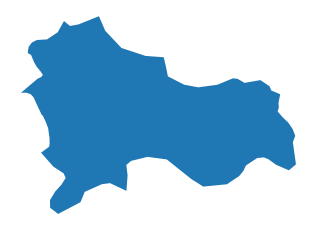

In [7]:
# Folder where data for running the notebook is stored
INPUT_DATA = Path("./data/") 

# Load geojson file
# country = gpd.read_file(INPUT_DATA.joinpath('ljubljana.geojson'))
country = gpd.GeoDataFrame(ljubljana_data, crs="EPSG:32632", index=[0])

# Apply a 500m buffer to the shape (indicate a specific feature with [i])
country_buffer = country[country.geometry.name][0].buffer(500)

# Get the country's shape in polygon format
country_shape = country.geometry.values[-1]

# Plot country
country.plot()
plt.axis('off')

# Print size and points count
print('Dimension of the area is {0:.0f} x {1:.0f} m2'.format(country_shape.bounds[2] - country_shape.bounds[0],
                                                             country_shape.bounds[3] - country_shape.bounds[1]))
print('Points count after buffer: ', len(list(country_buffer.exterior.coords)))

#### 1.1.2 Get simplified bands and plot geographical extent  that will be used in requests
**Note**: Make sure the points count does not exceed 1500 points after simplification.

Points count:  72


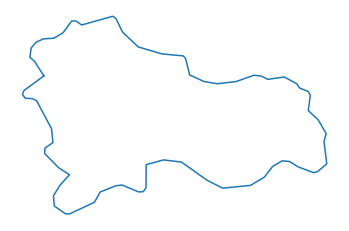

In [8]:
# Get the simplified shape of the country
country_sim = country_buffer.simplify(100) #unit in meter

# Check the amount of points forming the polygon
print('Points count: ',len(list(country_sim.exterior.coords)))

# Plot shape
plt.figure()
plt.axis('off')
plt.plot(*country_sim.exterior.xy)
plt.show()

## 1.2 Use Batch to fetch Sentinel-2 data and resample to even timesteps

Now that the area of interest is defined, we will set up the parameters necessary to run the `Batch` process, and go through the different steps to acquire the data.

We will collect Sentinel-2 data and retrieve the following products:

 - L1C custom list of bands [B02, B03, B04, B08, B11, B12], which corresponds to [B, G, R, NIR, SWIR1, SWIR2] wavelengths.

- Calculated NDVI, NDWI, and NDBI information

- A mask of validity, based on acquired data from Sentinel and cloud coverage. Valid pixel is if:
    - IS_DATA == True
    - CLOUD_MASK == 0 (1 indicates cloudy pixels and 255 indicates `NO_DATA`)
    
All returned products will be returned for specific time intervals between 2 dates. If no data is present on the interval date, the service returns a linear interpolation between the previous and following valid data. The `Batch` request merges the [EOLearn data download step](https://eo-learn.readthedocs.io/en/latest/examples/land-cover-map/SI_LULC_pipeline.html#Define-the-workflow) and [training data preparation step](https://eo-learn.readthedocs.io/en/latest/examples/land-cover-map/SI_LULC_pipeline.html#5.-Prepare-the-training-data) into one.

#### 1.2.1 Prepare Batch input parameters

Here we set the start and end date of the time interval that we want to query, as well as a time step in days for which data will be returned.

We also specify the name of the Amazon S3 Bucket that was created and parameterised as shown earlier.

In [9]:
# Date parameters: for this example, we will get data from early April to late October.
START = datetime.date(2019, 4, 1)
END = datetime.date(2019, 10, 31)

INTERVAL = 15  # Interval for date resampling in days

# Calculate list of dates for the resampling
date_iterator = START
timestamps = []
while date_iterator < END:
    timestamps.append(date_iterator)
    date_iterator = date_iterator + datetime.timedelta(days=INTERVAL)
    
# Amazon bucket name
aws_bucket_name = "my-amazon-bucket"

Below, we define the evalscript that will perform all the work on Sentinel Hub servers. The script fetches the images, calculates the indices (NDVI, NDWI, and NDBI), and resamples the data to the defined interval.

In [10]:
evalscript = """
//VERSION=3

// Calculate number of bands needed for all intervals
// Initialise dates and interval
// Beware: in JS months are 0 indexed
var start_date = new Date(2019, 3, 1, 0, 0, 0);
var end_date = new Date(2019, 9, 31, 0, 0, 0);
var sampled_dates = sample_timestamps(start_date, end_date, 15, 'day').map(d => withoutTime(d));
var nb_bands = sampled_dates.length;
var n_valid = 0;
var n_all = 0;

function interval_search(x, arr) {
  let start_idx = 0,  end_idx = arr.length - 2;

  // Iterate while start not meets end
  while (start_idx <= end_idx) {
    // Find the mid index
    let mid_idx = (start_idx + end_idx) >> 1;

    // If element is present at mid, return True
    if (arr[mid_idx] <= x && x < arr[mid_idx + 1]) {
      return mid_idx;
    }
    // Else look in left or right half accordingly
    else if (arr[mid_idx + 1] <= x) start_idx = mid_idx + 1;
    else end_idx = mid_idx - 1;
  }
  if (x == arr[arr.length-1]){
    return arr.length-2;
  }

  return undefined;
}

function linearInterpolation(x, x0, y0, x1, y1, no_data_value=NaN) {
  if (x < x0 || x > x1) {
    return no_data_value;
  }
  var a = (y1 - y0) / (x1 - x0);
  var b = -a * x0 + y0;
  return a * x + b;
}

function lininterp(x_arr, xp_arr, fp_arr, no_data_value=NaN) {
  results = [];
  data_mask = [];
  xp_arr_idx = 0;
  for(var i=0; i<x_arr.length; i++){
    var x = x_arr[i];
    n_all+=1;
    interval = interval_search(x, xp_arr);
    if (interval === undefined) {
      data_mask.push(0);
      results.push(no_data_value);
      continue;
    }
    data_mask.push(1);
    n_valid+=1;
    results.push(
      linearInterpolation(
        x,
        xp_arr[interval],
        fp_arr[interval],
        xp_arr[interval+1],
        fp_arr[interval+1], 
        no_data_value
      )
    );
  }

  return [results, data_mask];
}


function interpolated_index(index_a, index_b){
  // Calculates the index for all bands in array
  var index_data = [];
  for (var i = 0; i < index_a.length; i++){
     // UINT index returned
     let ind = (index_a[i] - index_b[i]) / (index_a[i] + index_b[i]);
     index_data.push(ind * 10000 + 10000);
  }
  
  return index_data
}


function increase(original_date, period, period_unit){
    date = new Date(original_date)
    switch(period_unit){
        case 'millisecond':
            return new Date(date.setMilliseconds(date.getMilliseconds()+period));
        case 'second':
            return new Date(date.setSeconds(date.getSeconds()+period));
        case 'minute':
            return new Date(date.setMinutes(date.getMinutes()+period));
        case 'hour':
            return new Date(date.setHours(date.getHours()+period));
        case 'day':
            return new Date(date.setDate(date.getDate()+period));
        case 'month':
            return new Date(date.setMonth(date.getMonth()+period));
        default:
            return undefined
    }
}

function sample_timestamps(start, end, period, period_unit) {
    var cDate = new Date(start);
    var sampled_dates = []
    while (cDate < end) {
        sampled_dates.push(cDate);
        cDate = increase(cDate, period, period_unit);
    }
    return sampled_dates;
}

function is_valid(smp){
  // Check if the sample is valid (i.e. contains no clouds or snow)
  let clm = smp.CLM;
  let dm = smp.dataMask;

  if (clm === 1 || clm === 255) {
        return false;
  } else if (dm !=1 ) {
        return false;
  } else {
  return true;
  }
}

function withoutTime(intime){
  // Return date without time
  intime.setHours(0, 0, 0, 0);
  return intime;
}


// Sentinel Hub functions
function setup() {
  // Setup input/output parameters
    return {
        input: [{
            bands: ["B02", "B03", "B04", "B08", "B11", "B12", "CLM", "dataMask"],
            units: "DN"
        }],
      output: [
          {id: "B02", bands: nb_bands, sampleType: SampleType.UINT16},
          {id: "B03", bands: nb_bands, sampleType: SampleType.UINT16},
          {id: "B04", bands: nb_bands, sampleType: SampleType.UINT16},
          {id: "B08", bands: nb_bands, sampleType: SampleType.UINT16},
          {id: "B11", bands: nb_bands, sampleType: SampleType.UINT16},
          {id: "B12", bands: nb_bands, sampleType: SampleType.UINT16},
          {id: "NDVI", bands: nb_bands, sampleType: SampleType.UINT16},
          {id: "NDWI", bands: nb_bands, sampleType: SampleType.UINT16},
          {id: "NDBI", bands: nb_bands, sampleType: SampleType.UINT16},
          {id: "data_mask", bands: nb_bands, sampleType: SampleType.UINT8}
      ],
    mosaicking: "ORBIT"
    }
}


// Evaluate pixels in the bands
function evaluatePixel(samples, scenes) {
  
  // Initialise arrays
  var valid_samples = {'B02':[], 'B03':[], 'B04':[], 'B08':[], 'B11':[], 'B12':[]}; 
  
  var valid_dates = []
  // Loop over samples. 
  for (var i = samples.length-1; i >= 0; i--){
      if (is_valid(samples[i])) {
        valid_dates.push(withoutTime(new Date(scenes[i].date)));
        valid_samples['B02'].push(samples[i].B02);
        valid_samples['B03'].push(samples[i].B03);
        valid_samples['B04'].push(samples[i].B04);
        valid_samples['B08'].push(samples[i].B08);
        valid_samples['B11'].push(samples[i].B11);
        valid_samples['B12'].push(samples[i].B12);
      }
  }
  
  var [b02_interpolated, b02_dm] = lininterp(sampled_dates, valid_dates, valid_samples['B02'], 0);
  var [b03_interpolated, b03_dm] = lininterp(sampled_dates, valid_dates, valid_samples['B03'], 0);
  var [b04_interpolated, b04_dm] = lininterp(sampled_dates, valid_dates, valid_samples['B04'], 0);
  var [b08_interpolated, b08_dm] = lininterp(sampled_dates, valid_dates, valid_samples['B08'], 0);
  var [b11_interpolated, b11_dm] = lininterp(sampled_dates, valid_dates, valid_samples['B11'], 0);
  var [b12_interpolated, b12_dm] = lininterp(sampled_dates, valid_dates, valid_samples['B12'], 0);

  // Calculate indices and return optimised for UINT16 format (will need unpacking)
  var ndvi = interpolated_index(b08_interpolated, b04_interpolated);
  var ndwi = interpolated_index(b03_interpolated, b08_interpolated);
  var ndbi = interpolated_index(b11_interpolated, b08_interpolated);
  
  // Return all arrays
  return {
            B02: b02_interpolated,
            B03: b03_interpolated,
            B04: b04_interpolated,
            B08: b08_interpolated,
            B11: b11_interpolated,
            B12: b12_interpolated,
            NDVI: ndvi,
            NDWI: ndwi,
            NDBI: ndbi,
            data_mask: b02_dm
  }
}
"""

Next, we set the parameters passed to the ```SentinelHubRequest()``` and the ```SentinelHubBatch()``` to run the batch processing request.

The following parameters are specified:

- **evalscript**: the evalscript that was written above.

- **geometry**: the geometry parameters representing the area of interest.

    The input type should be ```class 'shapely.geometry.polygon.Polygon'``` returned from [the “geometry” column](https://geopandas.org/data_structures.html) (```gdf[gdf.geometry.name][i]```).
    
- **crs**: the code corresponding to the projection parameters of the input data. 

    See the [input format](https://sentinelhub-py.readthedocs.io/en/latest/constants.html?highlight=SentinelHub.CRS#sentinelhub.constants.CRS) of the ```CRS``` helper for constant or enter in the following format: ```"EPSG: 3035"```.
    
- **datasource**: the parameters for the data to query.

    See the most commonly used [predefined datacollections](https://sentinelhub-py.readthedocs.io/en/latest/_modules/sentinelhub/data_collections.html#DataCollection) or [define a new data collection](https://sentinelhub-py.readthedocs.io/en/latest/examples/data_collections.html?highlight=DataCollection.define#Define-a-new-data-collection)

- **time_interval**: the start and end dates set the time period over which to fetch the data.

- **mosaickingOrder**: Choose from ```"mostRecent"```, ```"leastRecent"```, and ```"leastCC"``` (more [info](https://docs.sentinel-hub.com/api/latest/data/sentinel-2-l1c/#mosaickingorder)).

- **upsampling/downsampling**: Choose from ```"NEAREST"```, ```"BILINEAR"```, and ```"BICUBIC"``` ([examples for Sentinel-2](https://docs.sentinel-hub.com/api/latest/data/sentinel-2-l1c/#processing-options)).

- **output_type**: Use ```MimeType``` to select a data type of the output response returned by the evalscript (more [info](https://sentinelhub-py.readthedocs.io/en/latest/_modules/sentinelhub/constants.html#MimeType)).

- **tilingGridId** and **resolution**: these parameters parameters allow to set the grid and resolution of the images returned. To know which paramters to set, refer to the [dedicated documentation](https://docs.sentinel-hub.com/api/latest/api/batch/#tiling-grids). Here we return: 

    `tilingGridId` = 1, since less computation power is required for 10km grid. Larger tiling grids require more computational ressources.
    
    `resolution` = 10, which means our images will have a 10m resolution
    
- **buffer**: (Optional) A [buffer](https://sentinelhub-py.readthedocs.io/en/latest/sentinelhub_batch.html?highlight=SentinelHubBatch.tiling_grid#sentinelhub.sentinelhub_batch.SentinelHubBatch.tiling_grid) around each tile can be defined. 
    
    Set in the following format: ```(int,int)``` or ```None```.
    
- **bucketName**: the [configured](https://docs.sentinel-hub.com/api/latest/api/batch/#aws-s3-bucket-settings) Amazon S3 Bucket
- **description**: A personalised description for the request.

In [11]:
Evalscript = evalscript
geometry = country_sim
crs = CRS.UTM_32N
datasource = DataCollection.SENTINEL2_L1C
time_interval = (START, END)
mosaickingOrder = "mostRecent"
maxCloudCoverage = 1.0
upsampling = "NEAREST"
downsampling = "NEAREST"
output_type = MimeType.TIFF 
tilingGridId = 1 
resolution = 10 
buffer = (0, 0)
bucketName = aws_bucket_name 
description = "Slovenia LULC data example" 

In [12]:
request_shp = SentinelHubRequest(
    evalscript=Evalscript,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=datasource,
            time_interval=time_interval,
            mosaicking_order=mosaickingOrder,
            maxcc=maxCloudCoverage,
            upsampling=upsampling,
            downsampling=downsampling,
        )
    ],
    responses=[
        SentinelHubRequest.output_response("B02", output_type),
        SentinelHubRequest.output_response("B03", output_type),
        SentinelHubRequest.output_response("B04", output_type),
        SentinelHubRequest.output_response("B08", output_type),
        SentinelHubRequest.output_response("B11", output_type),
        SentinelHubRequest.output_response("B12", output_type),
        SentinelHubRequest.output_response("NDVI", output_type),
        SentinelHubRequest.output_response("NDWI", output_type),
        SentinelHubRequest.output_response("NDBI", output_type),
        SentinelHubRequest.output_response("data_mask", output_type)
    ],
    geometry=Geometry(geometry, crs=crs),
    config=config
)

batch = SentinelHubBatch(config=config)

batch_request = batch.create(
    request_shp,
    tiling_grid=SentinelHubBatch.tiling_grid(
        grid_id=tilingGridId,
        resolution=resolution,
        buffer=buffer
    ),
    bucket_name=bucketName,
    description=description
)

#### 1.2.2 Run the Batch request

Once all the parameters are set we are ready to run the `Batch` process. The batch processing API comes with the set of REST APIs which support the execution of various workflows. A diagram of the statuses of a batch processing request is located [here](https://docs.sentinel-hub.com/api/latest/api/batch/#workflow).

#### Start the request and return status



In [13]:
batch_request.to_dict()

{'id': '789fd6b7-7d4b-4cbf-9abc-67a1d9cc95e4',
 'processRequest': {'input': {'bounds': {'geometry': {'type': 'Polygon',
     'crs': {'type': 'name',
      'properties': {'name': 'urn:ogc:def:crs:EPSG::32632'}},
     'coordinates': [[[919628.9108834544, 5119356.917076456],
       [918749.0781451423, 5120862.307909182],
       [918333.910070902, 5121281.140880498],
       [918457.8990774148, 5122227.504274412],
       [918894.6468967017, 5122811.020878375],
       [919576.0567221006, 5123163.166090239],
       [920551.1006553276, 5123234.722209015],
       [921384.9902743214, 5123793.067258271],
       [922186.3912854855, 5125009.093105534],
       [922565.9886279197, 5125006.844256398],
       [923099.5064763993, 5124596.299383719],
       [925954.2380414003, 5125495.59598793],
       [926246.687521957, 5125258.720397337],
       [926849.6681557371, 5123868.441863545],
       [928300.4334644956, 5122333.2455211105],
       [930479.711624069, 5121614.0981342485],
       [932438.977014573

**Extract request id**

In [14]:
request_id = batch_request.to_dict()['id']

**Re-initialize the request with its request id (Optional)** 

In [15]:
# batch = SentinelHubBatch(config=config)

# reinit_request = batch.get_request(request_id)

# reinit_request.to_dict()

#### Show request status

In the cell below, we will check the status of the batch processing request. Because Batch Processing API is an asynchronous REST service, we can execute this cell all along the process to verify the progress of the request.

In [16]:
batch_request = batch.get_request(batch_request)

batch_request.status

<BatchRequestStatus.CREATED: 'CREATED'>

#### Additional analysis 

When executing the following cell:

- the status of the request changes to ANALYSING,
- the evalscript is validated,
- a list of required tiles is created, and
- the request's cost is estimated (i.e. the estimated number of processing units (PU) needed for the requested processing).
- After the analysis is finished the status of the request changes to ANALYSIS_DONE.

In [17]:
batch.start_analysis(batch_request)

''

Note: At this point you can run the **Show request status** cell again to check the status of the request.

In [18]:
while batch_request.status.value != 'ANALYSIS_DONE':
    batch_request = batch.get_request(batch_request)
    sleep(10)
    
batch_request.status

<BatchRequestStatus.ANALYSIS_DONE: 'ANALYSIS_DONE'>

**Estimate number of processing units**

Once analysis is completed the valueEstimate tells us an estimated number of processing units the batch job will cost.

In [19]:
print(f'Running this batch job will require approximately {batch_request.value_estimate:.4f} processing units')

Running this batch job will require approximately 6319.6816 processing units


**Check tile definitions**

we can check information about all tiles.

In [20]:
for tile_info in batch.iter_tiles(batch_request):
    print(tile_info)

{'id': 2558707, 'requestId': '789fd6b7-7d4b-4cbf-9abc-67a1d9cc95e4', 'geometry': {'type': 'Polygon', 'crs': {'type': 'name', 'properties': {'name': 'urn:ogc:def:crs:EPSG::4326'}}, 'coordinates': [[[14.352619160260875, 46.141743080954406], [14.351561800658885, 46.23173780922709], [14.481243368706025, 46.23239979824391], [14.482089292227679, 46.14240300576524], [14.352619160260875, 46.141743080954406]]]}, 'origin': {'type': 'Point', 'crs': {'type': 'name', 'properties': {'name': 'urn:ogc:def:crs:EPSG::32633'}}, 'coordinates': [450000.0, 5120000.0]}, 'name': '33TVM_5_8', 'status': 'PENDING'}
{'id': 2558708, 'requestId': '789fd6b7-7d4b-4cbf-9abc-67a1d9cc95e4', 'geometry': {'type': 'Polygon', 'crs': {'type': 'name', 'properties': {'name': 'urn:ogc:def:crs:EPSG::4326'}}, 'coordinates': [[[14.353671490381176, 46.051746910714016], [14.352619160260875, 46.141743080954406], [14.482089292227679, 46.14240300576524], [14.482931191867412, 46.05240477798336], [14.353671490381176, 46.051746910714016]]

Optionally, we can request information about a single tile.

In [21]:
# Specify a tile ID
TILE_ID = '2558718'

batch.get_tile(batch_request, TILE_ID)

{'id': 2558718,
 'requestId': '789fd6b7-7d4b-4cbf-9abc-67a1d9cc95e4',
 'geometry': {'type': 'Polygon',
  'crs': {'type': 'name',
   'properties': {'name': 'urn:ogc:def:crs:EPSG::4326'}},
  'coordinates': [[[14.482931191867412, 46.05240477798336],
    [14.482089292227679, 46.14240300576524],
    [14.611563448043396, 46.1429162944107],
    [14.612194893508299, 46.052916466242046],
    [14.482931191867412, 46.05240477798336]]]},
 'origin': {'type': 'Point',
  'crs': {'type': 'name',
   'properties': {'name': 'urn:ogc:def:crs:EPSG::32633'}},
  'coordinates': [460000.0, 5110000.0]},
 'name': '33TVM_6_9',
 'status': 'PENDING'}

#### START

Once you happy with the request parameters and have noted the number of PU consumed (by checking the *Show request status*), you can launch the processing.

**Note**: The processing time for this step could be up to an hour or more depending on the amount of data.

In [22]:
batch.start_job(batch_request)

''

#### Cancel the request
- When the job is running we can decide at any time to cancel it. Results that have already been produced will remain on the bucket.

In [23]:
#batch.cancel_job()

Note: At this point you can run the **Show request status** cell again to check the status of the request.

#### Show request status

In the cell below, we will check the status of the batch processing request. Because Batch Processing API is an asynchronous REST service, we can execute this cell all along the process to verify the progress of the request.

In [24]:
while batch_request.status.value != 'DONE':
    batch_request = batch.get_request(batch_request)
    sleep(10)

batch_request.status

<BatchRequestStatus.DONE: 'DONE'>

#### Visual tracking of the Batch request

The following cells allow us to track the progress of the Batch request by plotting the status of the tiles. To visually track the progress of the Batch request, we can keep executing the Plotting command.

In [25]:
def plot_batch_splitter(splitter):
    """ Plots tiles and area geometry from a splitter class
    """
    tile_geometries = [Geometry(bbox.geometry, bbox.crs) for bbox in splitter.get_bbox_list()]
    tile_geometries = [geometry.transform(splitter.crs) for geometry in tile_geometries]

    gdf = gpd.GeoDataFrame(
        {'status': [info['status'] for info in splitter.get_info_list()]},
        geometry=[geometry.geometry for geometry in tile_geometries],
        crs=splitter.crs.pyproj_crs()
    )
    ax = gdf.plot(column='status', legend=True, figsize=(10, 10))

    area_series = gpd.GeoSeries(
        [splitter.get_area_shape()],
        crs=splitter.crs.pyproj_crs()
    )
    area_series.plot(ax=ax, facecolor='none', edgecolor='black')


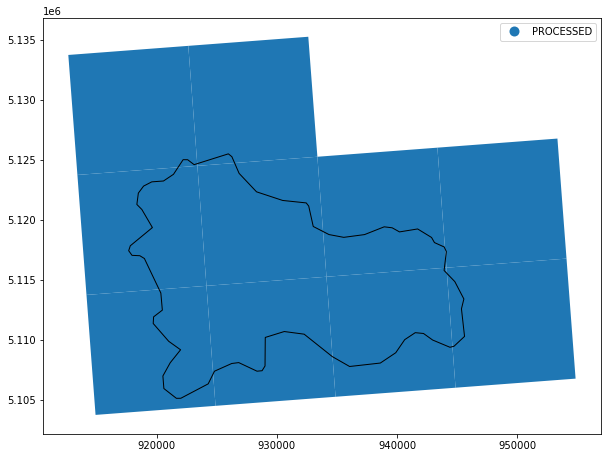

In [27]:
splitter = BatchSplitter(batch_request=batch_request, config=config)
plot_batch_splitter(splitter)

#### What if some of my tiles fail?

It can happen that some of the tiles are not processed, and appear with the status `FAILED` in the plot above. We can use the function defined below to restart the processing for those specific tiles.

In [28]:
# #Re-run the processing for all the tiles that failed
# batch.restart_job(batch_request)

Alternatively, we can re-run processing only for a single tile.

In [29]:
# # Specify an ID of a tile that failed
# FAILED_TILE_ID = ''

# batch.reprocess_tile(batch_request, FAILED_TILE_ID)

# Part 2: convert Batch process outputs to EOPatches

When the Batch request in **Part 1** has finished running, we should now have the data located in the specified Bucket. In **Part 2** we will focus on converting the results to EoPatches and download the data.

### 2.1 Set parameters for conversion 

First we specify a few parameters for converting the Batch results to EOLearn Patches.

If you want to pick up the Notebook after having run the Batch request in an other session, you will need to specify a few parameters that were already defined in **Part 1**: for that uncomment and run the next cell. If you have just executed the cells in **Part 1**, you can skip the next cell.

In [30]:
# # Date parameters
# START = datetime.date(2019, 4, 1)
# END = datetime.date(2019, 10, 31)

# INTERVAL = 15  # Interval for date resampling in days

# # Calculate list of dates for the resampling
# date_iterator = START
# timestamps = []
# while date_iterator < END:
#     timestamps.append(date_iterator)
#     date_iterator = date_iterator + datetime.timedelta(days=INTERVAL)
    
# #Amazon client ID and secret
# AWS_ID = "aws-client-id"
# AWS_SECRET = "aws-client-secret"
    
# # Amazon bucket name
# aws_bucket_name = "your-bucket-name"

# # Request ID (from the Batch processing)
# request_id = ""

# #Configuration
# config = SHConfig()

Next, we will set the bands that we want to import into the `EOPatches`. 

In this example we use: 
   - B02, B03, B04, B08, B11, B12 bands from Sentinel-2
   
   - NDVI, NDWI, NDBI indices
   
   - Valid data band

In [31]:
band_names = ['B02.tif', 'B03.tif', 'B04.tif', 'B08.tif', 'B11.tif','B12.tif',
              'NDVI.tif', 'NDWI.tif', 'NDBI.tif']
is_data_band = 'data_mask.tif'

Finally, let's specify the folder to which we will save the data.

In [32]:
# Output path
save_folder = "./results"

We have defined a class to convert the Batch Request to `EOPatches` for ease of use below.


In [33]:
class ImportFromAWS:
    """Import EoPatches from a Batch request.
    
    This class regroups all the methods to transform the saved results of a batch request
    located in an Amazon Bucket to EOPatches locally.
    
    :param aws_key: Amazon client ID
    :type aws_key: str
    :param aws_secret: Amazon secret
    :type aws_secret: str
    :param aws_bucket: Amazon bucket name where the batch results were written
    :type aws_bucket: str
    :param request_id: Batch request id
    :type request_id: str 
    param bands: List of bands that should be considered in the import
    :type bands: list 
    param timestamps: List of timestamps for resampled data
    :type timestamps: list
    param is_data: Name of the IS_DATA band from Batch
    :type is_data: str, optional
    :param out_path: Path to folder where EOPatches will be saved
    :type out_path: str, optional 
    """
    
    def __init__(self, aws_key, aws_secret, aws_bucket, request_id, bands, timestamps,
                 is_data=None, out_path="./"):
        """Constructor method.        
        """
        # Path to save the EoPatches
        self.out_path = Path(out_path)
            
        # Make directory
        self.out_path.mkdir(parents=True, exist_ok=True)

        # AWS credentials
        if (aws_key == None or aws_secret == None):
            raise ValueError("No Amazon credential provided!")
            
        # Create Amazon session and settings
        self.session = boto3.Session(aws_access_key_id=aws_key, 
                                     aws_secret_access_key=aws_secret,
                                    ) 
        self.s3_resource = self.session.resource('s3')
        self.s3_client = self.session.client('s3')
        self.bucket_name = aws_bucket
        self.bucket = self.s3_resource.Bucket(aws_bucket)
        
        # Set up filesytem for Amazon Bucket
        self.s3fs = S3FS(aws_bucket,
                         dir_path=request_id,
                         aws_access_key_id=aws_key,
                         aws_secret_access_key=aws_secret)
           
        # Request id
        self.request_id = request_id
        
        # Information about data and metadata
        self.is_data = is_data
        self.bands = bands
        self.timestamps = [x.isoformat() for x in timestamps]


    @staticmethod   
    def _open_band(AWS_session, bucket, request_id, folder, bandname):
        """Open Band.
        
        Using Rasterio, open a band in an Amazon S3 Bucket, and return bbox and data.
        
        :param session: Amazon boto session
        :type session: boto3.Session 
        :param bucket: Amazon bucket name
        :type bucket: str
        :param request_id: Name of the Batch request ID
        :type request_id: str
        :param folder: Name of the folder in which to query data
        :type folder: str
        :param bandname: Filename
        :type bandname: str 
        """
        # Open with Rasterio
        with rasterio.Env(rasterio.session.AWSSession(AWS_session)) as env:
            s3_url = f's3://{bucket}/{request_id}/{folder}/{bandname}'
            with rasterio.open(s3_url) as source:

                    bbox = BBox(source.bounds, CRS(source.crs.to_epsg()))
                    data = source.read()
        return data, bbox
    
    
    @staticmethod   
    def _open_local_band(band_path):
        """Open Local Band.
        
        Using Rasterio, open a band in an Amazon S3 Bucket, and return bbox and data.
        
        :param session: Amazon boto session
        :type session: boto3.Session 
        :param bucket: Amazon bucket name
        :type bucket: str
        :param request_id: Name of the Batch request ID
        :type request_id: str
        :param folder: Name of the folder in which to query data
        :type folder: str
        :param bandname: Filename
        :type bandname: str 
        """
        # Open with Rasterio
        with rasterio.open(band_path) as source:
            bbox = BBox(source.bounds, CRS(source.crs.to_epsg()))
            data = source.read()

        return (data, bbox)

    
    @staticmethod
    def _convert_DN(band, in_band):
        """Convert DN to values.
        
        It is cheaper to return INT data from SH Hub. In the evalscript a coefficient is applied
        to the data to return it as INT, and here it needs to be unpacked. This function (for now)
        considers only 2 ways of saving data: bands starting with B or indices not starting with B.
        
        :param band: Band name to convert
        :type band: str 
        :param in_band: Numpy array to convert
        :type in_band: np.array 
        :return: The input numpy array converted depending on band name
        :rtype: np.array
        """
        if band.startswith("B"):
            outband = in_band / 10000.
        else:
            outband = (in_band - 10000.) / 10000.

        return outband


    @staticmethod
    def _eopatch_import(folder_system, folders, bucket, bands, timestamps, out_path, local=False,
                        save_local=True, is_data=None, request_id=None, bucket_name=None, session=None):
        """Import EOPatches from local data.
        
        After having downloaded the bucket contents to a local folder, extract the EOPatches.
        
        :param folder_system: a fs sytem object containing base directory (S3 or local)
        :type folder_system: s3fs.S3FS or s3fs.core.S3FileSystem
        :param folders: List of folders to search through
        :type folders: list 
        :param bucket: boto3 resource Bucket bucket, see :class:`ImportFromAWS`
        :type bucket: boto3.S3.Bucket(name)
        :param bands: List of bands to process
        :type bands: list
        :param timestamps: List of timestamps corresponding to the bands
        :type timestamps: list
        :param out_path: Output folder where the EOPatches are saved
        :type out_path: str
        :param local: Set whether the folders are local or on Amazon S3
        :type local: bool, optional
        :param save_local: Set whether the EOPatches are saved to local or on Amazon S3
        :type save_local: bool, optional
        :param is_data: Name of band containing information of validity of data
        :type is_data: str, optional
        :param request_id: When importing from a Amazon bucket, folder name (from Batch)
        :type request_id: str, optional
        :param bucket_name: When importing from a Amazon bucket, bucket name
        :type bucket_name: str, optional
        :param session: When importing from a Amazon bucket, boto3 S3 session
        :type session: boto3.S3.session, optional

        """
        # Initialise counter
        nb_patch = 0
        
        # Ignore json file
        folders = [x for x in folders if not x.endswith("json")]
        
        # Loop over the folders which will become patches
        for fold in tqdm(folders):
          
            # Export switch (in case the bands are missing in a patch)
            export = True

            # Empty EOPatch to be filled
            eo_patch = EOPatch()

            # List bands in folder
            current_bands = folder_system.listdir(fold)
            
            # Check if the bands in the folder correspond to the bands wanted
            if any(elem in current_bands for elem in bands):
                all_bands = {}
                # Loop through bands
                for band in bands:
                    # Different opening method depending on local or not
                    if local:
                        band_data, data_bbox = ImportFromAWS._open_local_band(Path(
                            folder_system.getsyspath("")).joinpath(fold, band))
                    else:
                        band_data, data_bbox = ImportFromAWS._open_band(session, 
                                                                        bucket_name, 
                                                                        request_id,
                                                                        fold, band)
                    # Convert band to reflectance or index and save
                    all_bands[band] = ImportFromAWS._convert_DN(band, band_data)

                     # Get IS_DATA
                if is_data != None and is_data in current_bands:
                    # Different opening method depending on local or not
                    if local:
                        is_data_array, _ = ImportFromAWS._open_local_band(Path(
                                folder_system.getsyspath("")).joinpath(fold, is_data))
                    else:
                        is_data_array, _ = ImportFromAWS._open_band(session, 
                                                                    bucket_name, 
                                                                    request_id,
                                                                    fold, is_data)
            # If the bands don't match, skip the patch
            else:
                print(f"Bands don't match for Patch {fold}... skipping...")
                export = False

            # if not flag to skip the band, continue
            if export:
                # Add bbox to patch
                eo_patch.bbox = data_bbox

                # Add bands to patch
                eo_patch.data['FEATURES'] = np.stack([all_bands[x] for x in all_bands.keys()], axis=-1)
                
                # Add is data mask to patch
                eo_patch.mask["IS_DATA"] = np.expand_dims(is_data_array, axis=-1)

                # Add metadata
                eo_patch.meta_info["time_interval"] = (START.isoformat(), END.isoformat())
                eo_patch.meta_info["band_list"] = [x.split('.')[0] for x in bands]

                # Add timestamps
                eo_patch.timestamp = timestamps

                # Save EOPatch (either on local or on Bucket)
                if save_local:
                    save_path = str(Path(out_path).joinpath("EOPatches"))
                else:
                    save_path = f"s3://{bucket_name}/EOPatches"

                eo_patch.save(f"{save_path}/eopatch_{nb_patch}",
                              overwrite_permission=OverwritePermission.OVERWRITE_PATCH)

                # Increase counter
                nb_patch += 1


    def convert_to_EOPatches(self, local_bucket=None, save_locally=True):
        """Import of EOPatches.
        
        This function converts the contents of an Amazon bucket that is
        stored locally (after download using e.g. `download_S3_bucket`) or 
        stored on Amazon S3 to EOPatches.
        
        :param local_bucket: A local folder containing contents of a Bucket
        :type local_bucket: str, optional
        """
        
        if local_bucket is None:
            # Open Bucket as folder system
            folder_sys = self.s3fs
            # Set local flag to False
            local = False
        else:
            # Open local folder system
            folder_sys = open_fs(local_bucket)
            #Set local flag to True
            local = True

        # Get subfolders in the local folder
        folders = folder_sys.listdir("/")
        
        # Run the import
        self._eopatch_import(folder_sys, folders, self.bucket, self.bands, self.timestamps,
                             self.out_path, local=local, save_local=save_locally, is_data=self.is_data,
                             request_id=self.request_id, bucket_name=self.bucket_name, session=self.session)


    def download_from_bucket(self, obj_id="S3"):
        """Download S3 Bucket.
        
        Downloads the results of a batch request stored in an Amazon
        bucket, based on the request ID of the class.

        """
        # Check type
        if obj_id not in ["S3", "EO"]:
            raise ValueError("Not a correct object ID to download: choose S3 or EO")

        # Check if a folder named after the reques ID already exists in the output folder
        if obj_id == "S3":
            path = self.request_id
        else:
            path = "EOPatches"

        if self.out_path.joinpath(path).is_dir():
                raise ValueError("Bucket folder already exists on local path! Delete and try again.")
        
        # Download S3/EO bucket
        print("Downloading bucket contents")
        
        keys = []
        dirs = []
        next_token = ''
        base_kwargs = {
            'Bucket':self.bucket_name,
            'Prefix':path,
        }
        while next_token is not None:
            kwargs = base_kwargs.copy()
            if next_token != '':
                kwargs.update({'ContinuationToken': next_token})
            results = self.s3_client.list_objects_v2(**kwargs)
            contents = results.get('Contents')
            for i in contents:
                k = i.get('Key')
                if k[-1] != '/':
                    keys.append(k)
                else:
                    dirs.append(k)
                
            next_token = results.get('NextContinuationToken')

        for d in dirs:
            dest_pathname = self.out_path.joinpath(d)
            dest_pathname.mkdir(parents=True, exist_ok=True)

        for k in tqdm(keys):
            dest_pathname = self.out_path.joinpath(k)
            dest_pathname.parent.mkdir(parents=True, exist_ok=True)
            self.s3_client.download_file(self.bucket_name, k, str(dest_pathname))   


### 2.2 Run conversion from Batch results to EOPatches

Now all the parameters are set, we can run the conversion. For this step there are 2 available options:

1. Download the contents of the Amazon S3 Bucket to a local file and convert locally to `EOPatches`
2. Convert the data from the Amazon S3 Bucket and download the `EOPatches`

First, we make an object, initialising it with the necessary parameters to perform the conversion.

In [34]:
# Make class to convert Batch to EOPatches
batch2eolearn = ImportFromAWS(AWS_ID, AWS_SECRET, aws_bucket_name,
                              request_id, band_names, timestamps, is_data=is_data_band, 
                              out_path=save_folder)

#### Option 1: Dowload Bucket and convert locally

You can use the in-build function below to download your Amazon Bucket contents, or skip the cell and sync the Bucket using the aws cli tool.

In [35]:
# Download Batch results from Bucket
batch2eolearn.download_from_bucket(obj_id="S3")

  0%|          | 0/101 [00:00<?, ?it/s]

If you specify the folder name containing the Batch request data in the `convert_to_EOPatches` function, the conversion will be performed locally.

In [36]:
# Convert local data to EOPatches
batch2eolearn.convert_to_EOPatches(local_bucket=f"{save_folder}/{request_id}")

  0%|          | 0/10 [00:00<?, ?it/s]

#### Option 2: Convert in Bucket and download EOPatches

The following cell allows you to convert the data that is stored on the Amazon S3 Bucket. Using the `save_locally` True/False flag you can either directly save the EOPatches on your computer or store them on the Amazon S3 Bucket.

In [37]:
# Convert Batch results in the Amazon Bucket to EoPatches
# batch2eolearn.convert_to_EOPatches(save_locally=False)
batch2eolearn.convert_to_EOPatches(save_locally=False)

  0%|          | 0/10 [00:00<?, ?it/s]

If you save the EOPatches to your Amazon Bucket, you can either download them by using the inbuilt command below or using an other method of your choice (e.g. `aws cli`).

In [39]:
# Rename the folder created in option 1
os.rename("./results/EOPatches", "./results/EOPatches_opt1")

# Download EOPatches from Bucket
batch2eolearn.download_from_bucket(obj_id="EO")

  0%|          | 0/50 [00:00<?, ?it/s]

## Step 3: continue processing data using EOPatches

Now we have the EOPatches saved locally, we can continue the process as shown in the [example EOLearn Notebook](https://eo-learn.readthedocs.io/en/latest/examples.html#land-use-and-land-cover).

Before continuing with **Model construction and training** (see [here](https://eo-learn.readthedocs.io/en/latest/examples/land-cover-map/SI_LULC_pipeline.html#6.-Model-construction-and-training)) we will need to import the reference data for Slovenia first. Since we are querying data over Slovenia, we need to fetch the reference data for the whole country [here](http://eo-learn.sentinel-hub.com/).

For this example, the reference data prepared for Ljubljana can be downloaded [here](https://github.com/sentinel-hub/eo-learn/blob/master/examples/batch-processing/data/ljubljana_ref.gpkg).

### 3.1 Prepare the data to train the LULC prediction model

#### 3.1.1 Setup reference data

For this example, a subset of the country-wide reference for land-use-land-cover is provided. It is available in the form of a geopackage, which contains polygons and their corresponding labels. The labels represent the following 10 classes:

- lulcid = 0, name = no data
- lulcid = 1, name = cultivated land
- lulcid = 2, name = forest
- lulcid = 3, name = grassland
- lulcid = 4, name = shrubland
- lulcid = 5, name = water
- lulcid = 6, name = wetlands
- lulcid = 7, name = tundra
- lulcid = 8, name = artificial surface
- lulcid = 9, name = bareland
- lulcid = 10, name = snow and ice

In [40]:
class LULC(MultiValueEnum):
    """ Enum class containing basic LULC types
    """
    NO_DATA            = 'No Data',            0,  '#ffffff'
    CULTIVATED_LAND    = 'Cultivated Land',    1,  '#ffff00'
    FOREST             = 'Forest',             2,  '#054907'
    GRASSLAND          = 'Grassland',          3,  '#ffa500'
    SHRUBLAND          = 'Shrubland',          4,  '#806000'
    WATER              = 'Water',              5,  '#069af3'
    WETLAND            = 'Wetlands',           6,  '#95d0fc'
    TUNDRA             = 'Tundra',             7,  '#967bb6'
    ARTIFICIAL_SURFACE = 'Artificial Surface', 8,  '#dc143c'
    BARELAND           = 'Bareland',           9,  '#a6a6a6'
    SNOW_AND_ICE       = 'Snow and Ice',       10, '#000000'

    @property
    def id(self):
        """ Returns an ID of an enum type

        :return: An ID
        :rtype: int
        """
        return self.values[1]

    @property
    def color(self):
        """ Returns class color

        :return: A color in hexadecimal representation
        :rtype: str
        """
        return self.values[2]


def get_bounds_from_ids(ids):
    bounds = []
    for i in range(len(ids)):
        if i < len(ids) - 1:
            if i == 0:
                diff = (ids[i + 1] - ids[i]) / 2
                bounds.append(ids[i] - diff)
            diff = (ids[i + 1] - ids[i]) / 2
            bounds.append(ids[i] + diff)
        else:
            diff = (ids[i] - ids[i - 1]) / 2
            bounds.append(ids[i] + diff)
    return bounds


# Reference colormap things
lulc_bounds = get_bounds_from_ids([x.id for x in LULC])
lulc_cmap = ListedColormap([x.color for x in LULC], name="lulc_cmap")
lulc_norm = BoundaryNorm(lulc_bounds, lulc_cmap.N)

The main point of this task is to create a raster mask from the vector polygons and add it to the eopatch. With this procedure, any kind of a labeled shapefile can be transformed into a raster reference map. This result is achieved with the existing task `VectorToRaster` from the `eolearn.geometry package`. All polygons belonging to the each of the classes are separately burned to the raster mask.

In [41]:
# This step takes some time due to the large size of the reference data (https://github.com/sentinel-hub/eo-learn/blob/master/examples/batch-processing/data/ljubljana_ref.gpkg)
land_use_ref_path = INPUT_DATA.joinpath('ljubljana_ref.gpkg')

land_use_ref = gpd.read_file(land_use_ref_path)

rasterization_task = VectorToRasterTask(land_use_ref, (FeatureType.MASK_TIMELESS, 'LULC'),
                                    values_column='lulcid', raster_shape=(FeatureType.MASK, 'IS_DATA'),
                                    raster_dtype=np.uint8)

#### 3.1.2 Define the workflow

Now we want to incorporate the reference data to the EOPatches, we need to load and update the existing patches with the reference data (see [here](https://eo-learn.readthedocs.io/en/latest/examples/land-cover-map/SI_LULC_pipeline.html#Reference-map-task)). We also want to perform the erosion step shown in the [EOLearn LULC example](https://eo-learn.readthedocs.io/en/latest/examples/land-cover-map/SI_LULC_pipeline.html#5.-Prepare-the-training-data) in order to "clean" the data, as described in this [blog post](https://medium.com/sentinel-hub/land-cover-classification-with-eo-learn-part-2-bd9aa86f8500).

We will also prepare the model training data (see [here](https://eo-learn.readthedocs.io/en/latest/examples/land-cover-map/SI_LULC_pipeline.html#5.-Prepare-the-training-data)) by performing random spatial sampling of the EOPatches, and finally split patches for training/validation.


The following workflow is created and executed:

1. Load the existing EOPatches containing satellite data
2. Add rasterised reference data
3. Perform erosion task on reference data
4. Random spatial sampling of the EOPatches
5. Split patches for training/validation
6. Save updated EOPatches

First we set up the tasks:

In [42]:
# Task for LOAD
load = LoadTask(f"{save_folder}/EOPatches")

# TASK FOR EROSION
# erode each class of the reference map
erosion = ErosionTask(mask_feature=(FeatureType.MASK_TIMELESS,'LULC','LULC_ERODED'), disk_radius=1)

# TASK FOR SPATIAL SAMPLING
# Uniformly sample about pixels from patches
n_samples = 500000 # half of pixels (1000*1000 patches here)
ref_labels = list(range(11)) # reference labels to take into account when sampling
spatial_sampling = FractionSamplingTask(
    features_to_sample=[  # tag fields to sample
        (FeatureType.DATA, 'FEATURES', 'FEATURES_SAMPLED'),
        (FeatureType.MASK_TIMELESS, 'LULC_ERODED', 'LULC_ERODED_SAMPLED')],
    sampling_feature=(FeatureType.MASK_TIMELESS, 'LULC_ERODED'),
    fraction=0.5
)

# TASK FOR SAVING
save = SaveTask(f"{save_folder}/EOPatches", overwrite_permission=OverwritePermission.OVERWRITE_PATCH)

Then we wrap tasks into nodes:

In [43]:
# load_node = EONode(load, inputs=[], name="Load Task")
# erosion_node = EONode(erosion, inputs=[load_node], name="Erode Task")
# sampling_node = EONode(spatial_sampling, inputs=[erosion_node], name="Spatial Sampling Task")
# save_node = EONode(save, inputs=[sampling_node], name="Save Task")
linked_nodes = linearly_connect_tasks(
    (load, "Load Task"),
    (rasterization_task, "Rasterize Task"),
    (erosion, "Erode Task"), 
    (spatial_sampling, "Spatial Sampling Task"),
    (save, "Save Task")
)

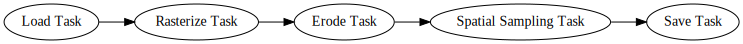

In [44]:
# Define the workflow
workflow = EOWorkflow(linked_nodes)

# Let's visualize it
workflow.dependency_graph()

#### 3.1.3 Run the EOWorkflow over all EOPatches


In [45]:
%%time
   
execution_args = []
for patch in Path(save_folder).joinpath("EOPatches").iterdir():
     execution_args.append({
         linked_nodes[0]: {'eopatch_folder': patch.name},
         linked_nodes[3]: {'seed': 42},
         linked_nodes[-1]: {'eopatch_folder': patch.name}
    })

executor = EOExecutor(workflow, execution_args, save_logs=True)
executor.run(workers=1, multiprocess=False)

executor.make_report()

  0%|          | 0/10 [00:00<?, ?it/s]

CPU times: user 51.1 s, sys: 48.8 s, total: 1min 39s
Wall time: 8min 23s


### 3.2 Visualize the patches

Now we have EOPatches ready for analysis, we can visualise them before continuing.


In [46]:
# Load a random patch
patch_ID = 5

**RGB True Color of a Patch**

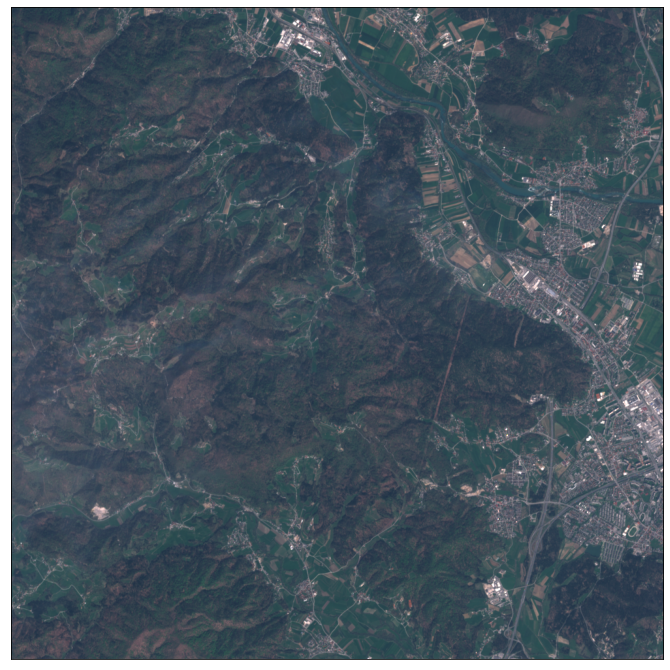

In [47]:
fig, ax = plt.subplots(1,figsize=(12,12))
eopatch = EOPatch.load(f'{save_folder}/EOPatches/eopatch_{patch_ID}', lazy_loading=True)
eopatch
ax.imshow(np.clip(eopatch.data['FEATURES'][1][..., [2, 1, 0]] * 3.5, 0, 1))
ax.set_xticks([])
ax.set_yticks([])
ax.set_aspect(1)
plt.show()
eopatch = None

**Temporal mean of NDVI of a patch**


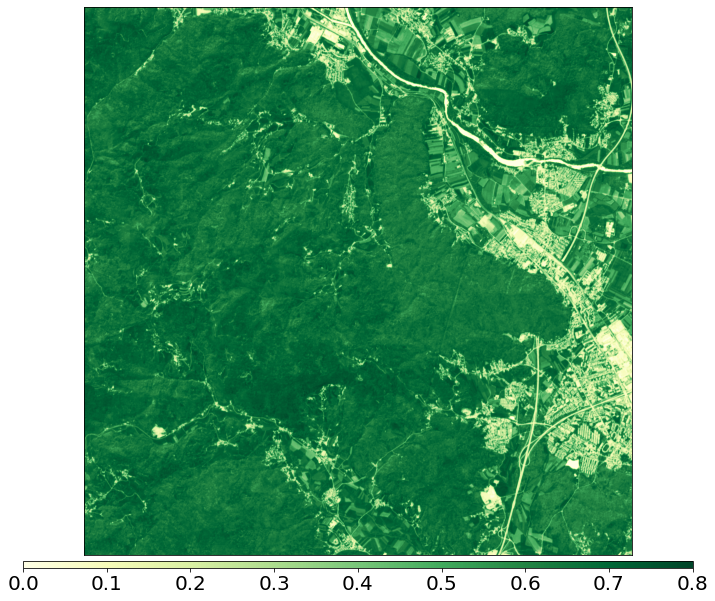

In [48]:
fig, ax = plt.subplots(figsize=(12,12))
eopatch = EOPatch.load(f'{save_folder}/EOPatches/eopatch_{patch_ID}', lazy_loading=True)
ndvi = eopatch.data['FEATURES'][:, :, :, 6]
mask = eopatch.mask['IS_DATA'].squeeze()
ndvi[mask==0] = np.nan
ndvi_mean = np.nanmean(ndvi, axis=0).squeeze()
im = ax.imshow(ndvi_mean, vmin=0, vmax=0.8, cmap=plt.get_cmap('YlGn'))
ax.set_xticks([])
ax.set_yticks([])
ax.set_aspect(1)
eopatch = None

cb = fig.colorbar(im, ax=ax, orientation='horizontal', pad=0.01, aspect=100)
cb.ax.tick_params(labelsize=20) 
plt.show()

**Reference data example of a Patch**

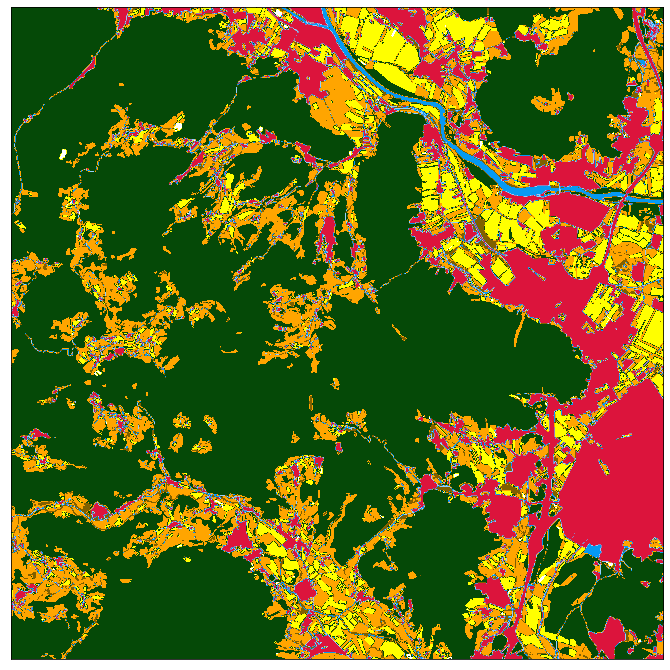

In [49]:
fig, ax = plt.subplots(figsize=(12,12))
eopatch = EOPatch.load(f'{save_folder}/EOPatches/eopatch_{patch_ID}', lazy_loading=True)

ax.imshow(eopatch.mask_timeless['LULC'].squeeze(), cmap=lulc_cmap, norm=lulc_norm)
ax.set_xticks([])
ax.set_yticks([])
ax.set_aspect(1)
eopatch = None

## Note:

At this point, we have a setup similar to what we would have at [Section 6](https://eo-learn.readthedocs.io/en/latest/examples/land-cover-map/SI_LULC_pipeline.html#6.-Model-construction-and-training) of the eo-learn LULC tutorial. If you are familiar with the process you can stop here, or you can continue the steps described in the [the eo-learn example](https://github.com/sentinel-hub/eo-learn/blob/master/examples/land-cover-map/SI_LULC_pipeline.ipynb) Notebook from here on.